# Quiz 3
MINE-4101: Applied Data Science  
Universidad de los Andes  
Estudiante: Alejandra Guerrero

In [1]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

### Descripción de los datos y limpieza

In [2]:
# Lectura de los datos en un dataframe
df = pd.read_csv("./datos/insurance.csv", encoding='utf8')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Transformacion de las variables binarias
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [5]:
# Transformacion de las variables categóricas
df = pd.get_dummies(data=df, columns=['region'], prefix=['reg'])

In [6]:
df.head()

,age,sex,bmi,children,smoker,charges,reg_northeast,reg_northwest,reg_southeast,reg_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


### Features to train the model

In [7]:
# Campos a incluir en la construcción del modelo
features = df.columns
features = features.drop('charges') 
features

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'reg_northeast',
       'reg_northwest', 'reg_southeast', 'reg_southwest'],
      dtype='object')

In [8]:
X = df[features]
Y = df['charges']

In [9]:
# Construcción del set de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [10]:
X_train.shape

(1070, 9)

In [11]:
X_test.shape

(268, 9)

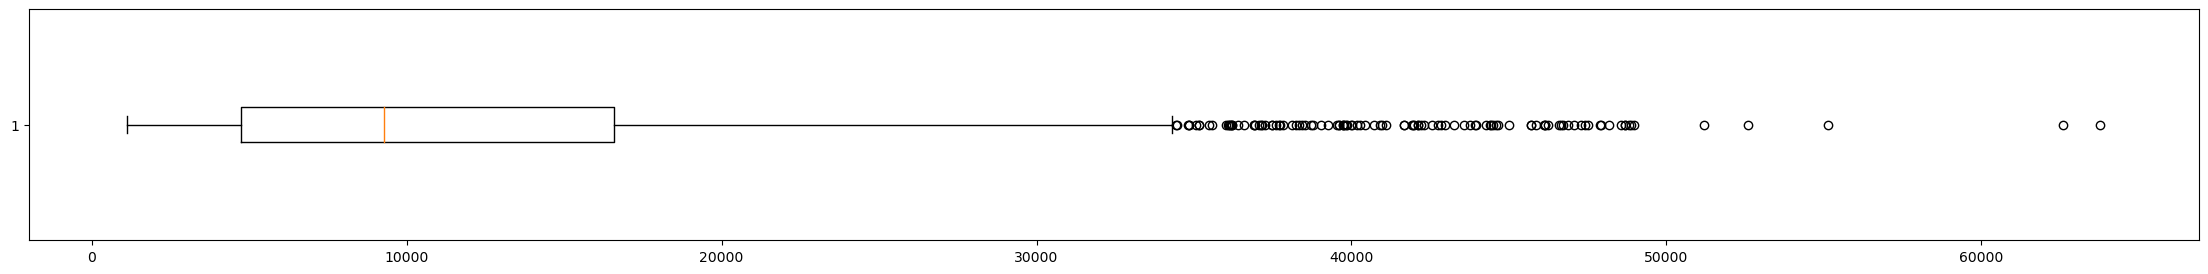

In [12]:
plt.figure(figsize = (28, 3))
plt.boxplot(Y_train, vert = False)
plt.show()

A partir de la gráfica anterior se identifican bastantes outliers en el set de entrenamiento, es decir, saldos que no se encuentran cerca del rango intercuartil.

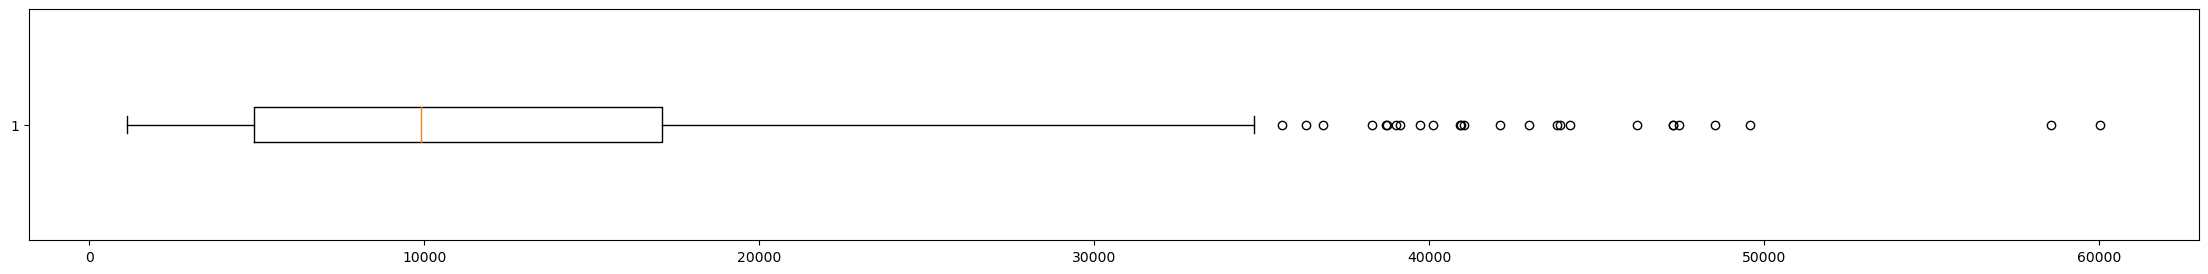

In [13]:
plt.figure(figsize = (28, 3))
plt.boxplot(Y_test, vert = False)
plt.show()

El set de prueba tiene un comportamiento similar al set de entrenamiento. Se identifican bastantes saldos que no se encuentran cerca del rango intercuartil.

### Scaling features

In [14]:
scaler = StandardScaler()

In [15]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Training the model

In [16]:
regr = LinearRegression()

In [17]:
# Entrenamiento del modelo
regr.fit(X_train_scaled, Y_train)

LinearRegression()

In [18]:
# Coeficientes del modelo generado
regr.coef_

array([3595.43999401, -121.05538036, 1969.23968492,  492.75838658,
       9613.18531706,  254.34544825,   83.36933982, -197.21188927,
       -134.97505592])

In [19]:
# Intercepto del modelo generado
regr.intercept_

13230.161574933647

De acuerdo con los coeficientes obtenidos, Las variables más importantes para predecir la variable "charges" son: smoker, age y bmi.

### Evaluating the model

In [20]:
# Evaluación del modelo
preds_train = regr.predict(X_train_scaled)
preds_test = regr.predict(X_test_scaled)

In [21]:
# Cálculo del MAE
mean_absolute_error(Y_train, preds_train), mean_absolute_error(Y_test, preds_test)

(4168.751118732005, 4051.858766747046)

In [22]:
# Cálculo del RMSE
np.sqrt(mean_squared_error(Y_train, preds_train)), np.sqrt(mean_squared_error(Y_test, preds_test))

(6065.291120009164, 5956.454717976427)

El set de entrenamiento y set de prueba tienen un error similar. Por tanto, no se identifica que el modelo esté sobreajustado (overfitting).

### Error analysis

In [23]:
# Comparación del valor real con el valor generado por el modelo
(Y_test - preds_test).describe(percentiles = [.25, .5, .75, .95, .99])

count      268.000000
mean        65.443115
std       5967.238510
min     -10696.432397
25%      -2533.838274
50%       -993.576702
75%       1222.670644
95%       9795.606908
99%      20253.425024
max      25439.753770
Name: charges, dtype: float64

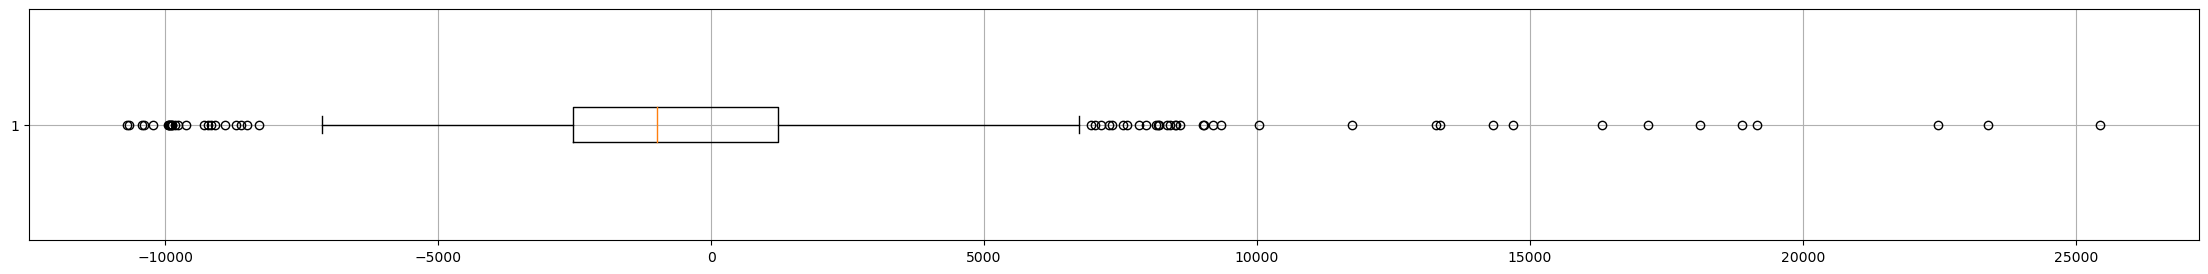

In [24]:
plt.figure(figsize = (28, 3))
plt.boxplot((Y_test - preds_test), vert = False)
plt.grid()
plt.show()

El rango intercuartil de la diferencia del error del set es pequeño, no supera los |2500|. No se identifica que el modelo esté sobreajustado.

In [25]:
worst_condition = np.where((Y_test - preds_test) > 3, True, False)

In [26]:
worst_cases = pd.concat([
    X_test.loc[worst_condition],
    Y_test.loc[worst_condition]
], axis = 1).reset_index(drop = True)

In [27]:
worst_cases['predictions'] = pd.Series(preds_test).loc[worst_condition].reset_index(drop = True)

In [28]:
worst_cases.shape

(96, 11)

In [29]:
# Casos con peor predicción
worst_cases

,age,sex,bmi,children,smoker,reg_northeast,reg_northwest,reg_southeast,reg_southwest,charges,predictions
0,21,1,22.300,1,0,0,0,0,1,2103.08000,544.728328
1,31,1,34.390,3,1,0,1,0,0,38746.35510,32117.584008
2,60,0,24.530,0,0,0,0,1,0,12629.89670,11002.813943
3,33,1,22.705,0,0,0,1,0,0,21984.47061,3863.743579
4,59,0,36.520,1,0,0,0,1,0,28287.89766,15009.631211
...,...,...,...,...,...,...,...,...,...,...,...
91,19,1,20.425,0,0,0,1,0,0,1625.43375,-474.417791
92,61,0,36.385,1,1,1,0,0,0,48517.56315,40306.054674
93,39,1,35.300,2,1,0,0,0,1,40103.89000,33555.184440
94,44,0,38.950,0,1,0,1,0,0,42983.45850,35949.523051


### Transformación polinomial

#### Polinomio de grado 2, alpha=0.1

In [30]:
poly_features = PolynomialFeatures(degree=2, include_bias= False)

In [31]:
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [32]:
ridge_reg = Ridge(alpha=0.1, solver='cholesky')
ridge_reg.fit(X_train_poly, Y_train)

Ridge(alpha=0.1, solver='cholesky')

In [33]:
# Evaluación del modelo
preds_train_reg = ridge_reg.predict(X_train_poly)
preds_test_reg = ridge_reg.predict(X_test_poly)

In [34]:
# Cálculo del RMSE
np.sqrt(mean_squared_error(Y_train, preds_train_reg)), np.sqrt(mean_squared_error(Y_test, preds_test_reg))

(4780.923515473981, 4530.693101847036)

#### Polinomio de grado 2, alpha=0.01

In [35]:
poly_features = PolynomialFeatures(degree=2, include_bias= False)

In [36]:
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [37]:
ridge_reg = Ridge(alpha=0.01, solver='cholesky')
ridge_reg.fit(X_train_poly, Y_train)

Ridge(alpha=0.01, solver='cholesky')

In [38]:
# Evaluación del modelo
preds_train_reg = ridge_reg.predict(X_train_poly)
preds_test_reg = ridge_reg.predict(X_test_poly)

In [39]:
# Cálculo del RMSE
np.sqrt(mean_squared_error(Y_train, preds_train_reg)), np.sqrt(mean_squared_error(Y_test, preds_test_reg))

(4780.9090127693125, 4529.660653503293)

#### Polinomio de grado 3, alpha=0.01

In [40]:
poly_features = PolynomialFeatures(degree=3, include_bias= False)

In [41]:
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

In [42]:
ridge_reg = Ridge(alpha=0.01, solver='cholesky')
ridge_reg.fit(X_train_poly, Y_train)

Ridge(alpha=0.01, solver='cholesky')

In [43]:
# Evaluación del modelo
preds_train_reg = ridge_reg.predict(X_train_poly)
preds_test_reg = ridge_reg.predict(X_test_poly)

In [44]:
# Cálculo del RMSE
np.sqrt(mean_squared_error(Y_train, preds_train_reg)), np.sqrt(mean_squared_error(Y_test, preds_test_reg))

(4565.340557466685, 4841.436431544905)

### Resultados

| Tipo de regresion | Alpha | RMSE del set de entrenamiento | RMSE del set de prueba |
| --- | --- | --- | --- |
| Lineal | NA | 6065.29 | 5956.45 |
| Polinomio de grado 2 | 0.1 | 4780.92 | 4530.69 |
| Polinomio de grado 2 | 0.01 | 4780.90 | 4529.66 |
| Polinomio de grado 3 | 0.01 | 4565.34 | 4841.43 |

Punto a

i. Considerando que los saldos de la variable Charges pueden estar en euros o en dólares, para una persona interesada en saber el saldo de su factura, no es aceptable un error de 4529 o mayor.

ii. No se identifica overfitting, el modelo no parece sobreajustado al tener un comportamiento similar en el error tanto en el entrenamiento como en las pruebas

Punto b

i. El modelo mejoró al considerar un tipo de regresión polinomial, en lugar de lineal. También se identificó una mejora al incluir 3 grados y no 2. A nivel de la regularización Ridge, no se evidenció una mejora significativa al aplicar un alpha de 0.1 o 0.01.

ii. De acuerdo con los coeficientes obtenidos, Las variables más importantes para predecir la variable "charges" parecen ser: smoker, age y bmi.